In [1]:
import os
import pandas as pd 
import numpy as np

In [2]:
data_dir = 'Data/CSV'
dataframes = []
for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    target = file_name[:-4] # remove ".csv"
    taget = target.split('_')[0] 

    df = pd.read_csv(file_path)
    #df.fillna(0, inplace=True)
    df['target'] = target
    dataframes.append(df)
    
    print(f"Number of {target}: " + str(df.shape[0]))

data = pd.concat(dataframes)
    

Number of bruteforce: 14501
Number of slowite: 9202
Number of flood: 613


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_77530/288588617.py:8: DtypeWarning: Columns (21,23,34,39,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of legitimate_1w: 11915716
Number of malformed: 10924


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_77530/288588617.py:8: DtypeWarning: Columns (21,23,34,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of malaria: 130223


# Distribution

<AxesSubplot: >

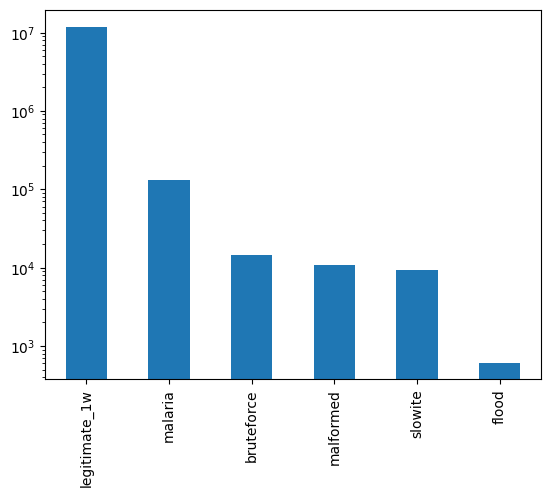

In [3]:
data['target'].value_counts().plot(kind='bar',logy=True)

# Drop Useless Columns

In [4]:
cols_to_drop = ['frame.time_invalid', 'frame.time_epoch', 'frame.time_relative', 'frame.number',
            'frame.time_delta', 'frame.time_delta_displayed', 'frame.cap_len', 'frame.len',
            'tcp.window_size_value', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.proto',
            'tcp.srcport', 'tcp.dstport', 'tcp.analysis.initial_rtt', 'tcp.stream', 'mqtt.topic',
            'tcp.checksum', 'mqtt.topic_len', 'mqtt.passwd_len', 'mqtt.passwd', 'mqtt.clientid',
            'mqtt.clientid_len', 'mqtt.username', 'mqtt.username_len']

col_empty = ['mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic', 'mqtt.willtopic_len']

data.drop(columns=cols_to_drop+col_empty, inplace=True)

In [5]:
print(data.dtypes.to_string())

tcp.flags                      object
tcp.time_delta                float64
tcp.len                         int64
mqtt.conack.flags              object
mqtt.conack.flags.reserved    float64
mqtt.conack.flags.sp          float64
mqtt.conack.val               float64
mqtt.conflag.cleansess        float64
mqtt.conflag.passwd           float64
mqtt.conflag.qos              float64
mqtt.conflag.reserved         float64
mqtt.conflag.retain           float64
mqtt.conflag.uname            float64
mqtt.conflag.willflag         float64
mqtt.conflags                  object
mqtt.dupflag                  float64
mqtt.hdrflags                  object
mqtt.kalive                   float64
mqtt.len                      float64
mqtt.msg                       object
mqtt.msgid                    float64
mqtt.msgtype                  float64
mqtt.proto_len                float64
mqtt.protoname                 object
mqtt.qos                      float64
mqtt.retain                   float64
mqtt.sub.qos

# Impute Null Values

In [6]:
num_columns = data.select_dtypes(['int','float']).columns
cat_columns = data.select_dtypes(['object']).columns
data[cat_columns] = data[cat_columns].fillna('None')

In [7]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

sub_data = data[num_columns]
data[num_columns] = imp_mean.fit_transform(sub_data)

In [8]:
data.isna().sum()

tcp.flags                     0
tcp.time_delta                0
tcp.len                       0
mqtt.conack.flags             0
mqtt.conack.flags.reserved    0
mqtt.conack.flags.sp          0
mqtt.conack.val               0
mqtt.conflag.cleansess        0
mqtt.conflag.passwd           0
mqtt.conflag.qos              0
mqtt.conflag.reserved         0
mqtt.conflag.retain           0
mqtt.conflag.uname            0
mqtt.conflag.willflag         0
mqtt.conflags                 0
mqtt.dupflag                  0
mqtt.hdrflags                 0
mqtt.kalive                   0
mqtt.len                      0
mqtt.msg                      0
mqtt.msgid                    0
mqtt.msgtype                  0
mqtt.proto_len                0
mqtt.protoname                0
mqtt.qos                      0
mqtt.retain                   0
mqtt.sub.qos                  0
mqtt.suback.qos               0
mqtt.ver                      0
target                        0
dtype: int64

# preprocess feature columns

In [9]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

features_to_encode = []
for col, dtype in data.dtypes.iteritems():
    # skip target 
    if col == 'target':
        continue
    # encode string features
    if str(dtype) == "object":
        print(col, dtype, data[col].unique().shape)
        # null was converted to 0, need to be converted to string for the encoder
        data[col] = data[col].astype(str)
        features_to_encode.append(col)

sub_data = data[features_to_encode]
enc.fit(sub_data)
print(enc.categories_)
data[features_to_encode] = enc.transform(sub_data)


tcp.flags object (8,)
mqtt.conack.flags object (2,)
mqtt.conflags object (4,)
mqtt.hdrflags object (14,)
mqtt.msg object (50412,)
mqtt.protoname object (2,)
[array(['0x00000002', '0x00000004', '0x00000010', '0x00000011',
       '0x00000012', '0x00000014', '0x00000018', '0x00000019'],
      dtype=object), array(['0x00000000', 'None'], dtype=object), array(['0x00000002', '0x00000082', '0x000000c2', 'None'], dtype=object), array(['0x00000010', '0x00000020', '0x00000030', '0x00000031',
       '0x00000032', '0x0000003a', '0x00000040', '0x00000050',
       '0x00000082', '0x00000090', '0x000000c0', '0x000000d0',
       '0x000000e0', 'None'], dtype=object), array(['24746f706963', '2d31', '2d3130', ..., '74657374',
       '746573747465737474657374', 'None'], dtype=object), array(['MQTT', 'None'], dtype=object)]


# Encode labels

In [10]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()

lenc.fit(data['target'])
print(lenc.classes_)
data['target'] = lenc.transform(data['target'])

['bruteforce' 'flood' 'legitimate_1w' 'malaria' 'malformed' 'slowite']


# Correlation Analysis

In [11]:
corr = data.corr()

In [12]:
corr.style.background_gradient(cmap='coolwarm')

/Users/amos/opt/miniconda3/envs/ds/lib/python3.8/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/amos/opt/miniconda3/envs/ds/lib/python3.8/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.uname,mqtt.conflag.willflag,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,target
tcp.flags,1.000000,0.101306,0.019609,-0.012695,nan,nan,0.000000,nan,0.000000,nan,nan,nan,0.000000,nan,-0.011516,-0.039497,-0.974474,0.000000,-0.058952,-0.947469,-0.005338,0.000849,nan,-0.012695,-0.060169,-0.002143,nan,nan,nan,-0.016928
tcp.time_delta,0.101306,1.000000,-0.002703,0.002169,nan,nan,0.000005,nan,-0.000001,nan,nan,nan,-0.000001,nan,0.001972,-0.003748,-0.006900,-0.000000,-0.073767,0.027704,-0.000179,0.454973,nan,0.002174,-0.006865,-0.000345,nan,nan,nan,-0.009896
tcp.len,0.019609,-0.002703,1.000000,0.000808,nan,nan,-0.000000,nan,0.000267,nan,nan,nan,0.000266,nan,-0.001219,0.186539,-0.049163,-0.001596,0.301271,-0.036732,0.015291,-0.013264,nan,-0.001467,0.302855,0.011397,nan,nan,nan,0.101378
mqtt.conack.flags,-0.012695,0.002169,0.000808,1.000000,nan,nan,-0.000000,nan,0.000000,nan,nan,nan,0.000000,nan,-0.000247,0.000000,0.016294,0.000000,0.014410,-0.020435,0.000000,0.017070,nan,-0.000273,0.000000,0.000000,nan,nan,nan,-0.056073
mqtt.conack.flags.reserved,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mqtt.conack.flags.sp,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mqtt.conack.val,0.000000,0.000005,-0.000000,-0.000000,nan,nan,1.000000,nan,-0.000000,nan,nan,nan,-0.000000,nan,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,nan,-0.000000,-0.000000,-0.000000,nan,nan,nan,-0.229573
mqtt.conflag.cleansess,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mqtt.conflag.passwd,0.000000,-0.000001,0.000267,0.000000,nan,nan,-0.000000,nan,1.000000,nan,nan,nan,0.997528,nan,0.420569,0.000000,-0.000000,-0.582626,-0.008021,-0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,nan,nan,nan,-0.228722
mqtt.conflag.qos,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

cols_correlations = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
cols_nan = [column for column in corr.columns if np.isnan(corr['target'][column])]

In [14]:
data.drop(columns=set(cols_correlations + cols_nan), inplace=True)

# Cast feature types

In [15]:
features = data.drop(columns=['target'])
features = features.astype(np.float64)
labels   = data['target']

# Train/Test Split and Save to files

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [17]:
def save_file(df, file_name):
    save_dir = 'Data'
    df.to_csv(os.path.join(save_dir, file_name), index = False, header=True)

X_train['target'] = y_train
save_file(X_train, 'train.csv')

X_test['target'] = y_test
save_file(X_test, 'test.csv')

In [18]:
X_train.columns

Index(['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags',
       'mqtt.conack.val', 'mqtt.conflag.passwd', 'mqtt.conflags',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len',
       'mqtt.msgid', 'mqtt.msgtype', 'mqtt.retain', 'target'],
      dtype='object')